In [6]:
import pandas as pd
import glob
pd.options.mode.chained_assignment = None 
import datetime
#import seaborn as sns
import datetime
import matplotlib.pyplot as plt
#% matplotlib inline


# PATHS

#Den Bosch flow
path = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150/RG8150/"
path1 = "../data/waterschap-aa-en-maas_sewage_2019_db_pumps/sewer_data_db/data_wwtp_flow/RG1876_flow/"
path2 = "../data/waterschap-aa-en-maas_sewage_2019_db_pumps/sewer_data_db/data_wwtp_flow/RG1882_flow/"


#Bokhoven level
path3 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8180_L0/"
#Bokhoven flow
path4 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8180_Q0/"


#Haarsteeg level
path5 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/rg8170_N99/"
#Haarsteeg flow
path6 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/rg8170_99/"


#Helftheuvelweg level column 003 Helftheuvelweg *.csv
path7 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Helftheuvelweg flow 
path8 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT301_99/"


#Engelerschans level column “004 Engelerschans” *.csv
path9 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Engelerschans flow + Haarsteeg + Bokhoven, therefore substract for only Engeleschans
path10 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT201_99/"


#Maaspoort level Column: “006 Maaspoort” *.csv 
path11 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Maasport flow + Rompert
path12= "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT501_99/"


#Oude Engelenseweg level Column: “002 Oude Engelenseweg” *.csv
path13 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Oude Engelenseweg flow
path14 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT401_94/"


#De Rompert level Column: “005 de Rompert” *.csv
path15 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#De Rompert flow + Maasport
path16 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT501_99/"

#Location linkage
path_linkinfo = "../data/waterschap-aa-en-maas_sewage_2019/sewer_model"
path_rain = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries"

#Missing Engelerschans (in map also)
station_names = ["Haarsteeg", "Bokhoven", "Hertogenbosch (Helftheuvelweg)",
                 "Hertogenbosch (Rompert)", "Hertogenbosch (Oude Engelenseweg)",
                 "Hertogenbosch (Maasport)"]

# link = pd.read_csv(path_linkinfo+
#                    "/20180717_dump riodat rioleringsdeelgebieden_matched_to_rainfall_locations.csv",
#                    header = 9)
link = pd.read_excel(path_linkinfo+
                     "/20180717_dump riodat rioleringsdeelgebieden_matched_to_rainfall_locations.xlsx",
                     header = 9)

rain = pd.concat([pd.read_csv(file, header = 2) for file in glob.glob(path_rain+"/*.*")], ignore_index = True)

def streets_rain(station_names, link, rain_df):
    
    #Street names by stations
    streets = [list(link[(link["Naam kern"] == name)]["Naam / lokatie"]) for name in station_names]

    #Streets that are not found in rainfall data belonging to Hertogenbosch (Oude Engelenseweg)
    excl = ['Pettelaarpark', 'Geb. 16 Paleiskwartier']

    for s in streets:
        try:
            for i in excl:
                s.remove(i)
        except ValueError:
            pass


    #All the rain for the streets for the pump stations in order of station_names and the streets per station
    #can be found in streets nested list in the same order
    station_to_rain = rain[["Begin", "Eind"] + [i for sl in streets for i in sl]]

    station_rain = pd.DataFrame()
    for i in range(len(station_names)):
        station_rain[station_names[i]] = rain[streets[i]].sum(1)

    station_rain["Begin"] =  station_to_rain["Begin"]
    station_rain["End"] = station_to_rain["Eind"]
    station_rain["Begin"] = pd.to_datetime(station_rain["Begin"])
    station_rain["End"] = pd.to_datetime(station_rain["End"])
    station_rain["date"] = station_rain["Begin"].dt.date
    return station_rain.sort_values(by=["Begin"])

df = streets_rain(station_names, link, rain)

In [7]:
def labeler3(dayrain, previousdayrain):
    """
    Classifies a whole day as dry if previous OR the same day has less than 0.05
    """
    if dayrain <= 0.05 or previousdayrain <= 0.05:
        return "0"
    else:
        return "1"
        
def rainyday(df, station_names):
    """
    Returns a list with DFs per station for dry day classification
    """
    df_rainyday = df.groupby(df["Begin"].dt.date).sum().reset_index(drop=False)
    
    events_df = []
    
    for i in station_names:
        df_relevant = df[[i, "Begin"]]
        df_relevant["previousday"] = df_relevant[i].shift(-1)
        df_relevant["dryday"] = df_relevant.apply(lambda x: labeler3(x[i], x["previousday"]), axis=1)
        events_df.append(df_relevant)
        
    return events_df


rainy_day_stations = rainyday(df, station_names)    

In [8]:
def labeler2(rain):
    """
    Classifies an hour as dry if there hasn't been rain previous n days days
    """
    if rain == 0:
        return "0"
    else:
        return "1"
    
def rain_events2(station_names, df, n):
    events_df = []
    df = df.sort_values(by="Begin")
    
    df = df.set_index("Begin", drop = False).resample("60Min").sum()
    df = df.reset_index(drop=False)
    
    for i in station_names:
        df_relevant = df[[i, "Begin"]]
        df_relevant["cumsum_previous_15"] = df[i].rolling(min_periods=1, window=n).sum()
        df_relevant["rain_-15_class"] = df_relevant.apply(lambda x: labeler2(x["cumsum_previous_15"]), axis=1)
        events_df.append(df_relevant)
    return events_df

# Here n = 15
#events_df = rain_events2(station_names, df, 15)

In [11]:

counter = 0
def labeler(rain, previous_rain):
    """
    Labels rain events (events are defined as consecutive measurements where there is no stop of rain)
    (Previous definition)
    """
    global counter
    if rain == 0:
        return "None"
    else:
        if previous_rain == 0:
            counter += 1
            return counter
        if previous_rain != 0:
            return counter
        
def rain_events(station_names, df):
    events_df = []
    df = df.sort_values(by="Begin")
    
    for i in station_names:
        df_relevant = df[[i, "Begin", "End"]]
        df_relevant["instr"] = df_relevant[i].shift()
        df_relevant["rain_event_ID"] = df_relevant.apply(lambda x: labeler(x[i], x["instr"]), axis=1)
        df_relevant.drop(columns=["instr"], inplace=True)
        events_df.append(df_relevant)
    return events_df

events_df = rain_events(station_names, df)

# Visualizing amount of rain (mm) against duration (minutes)

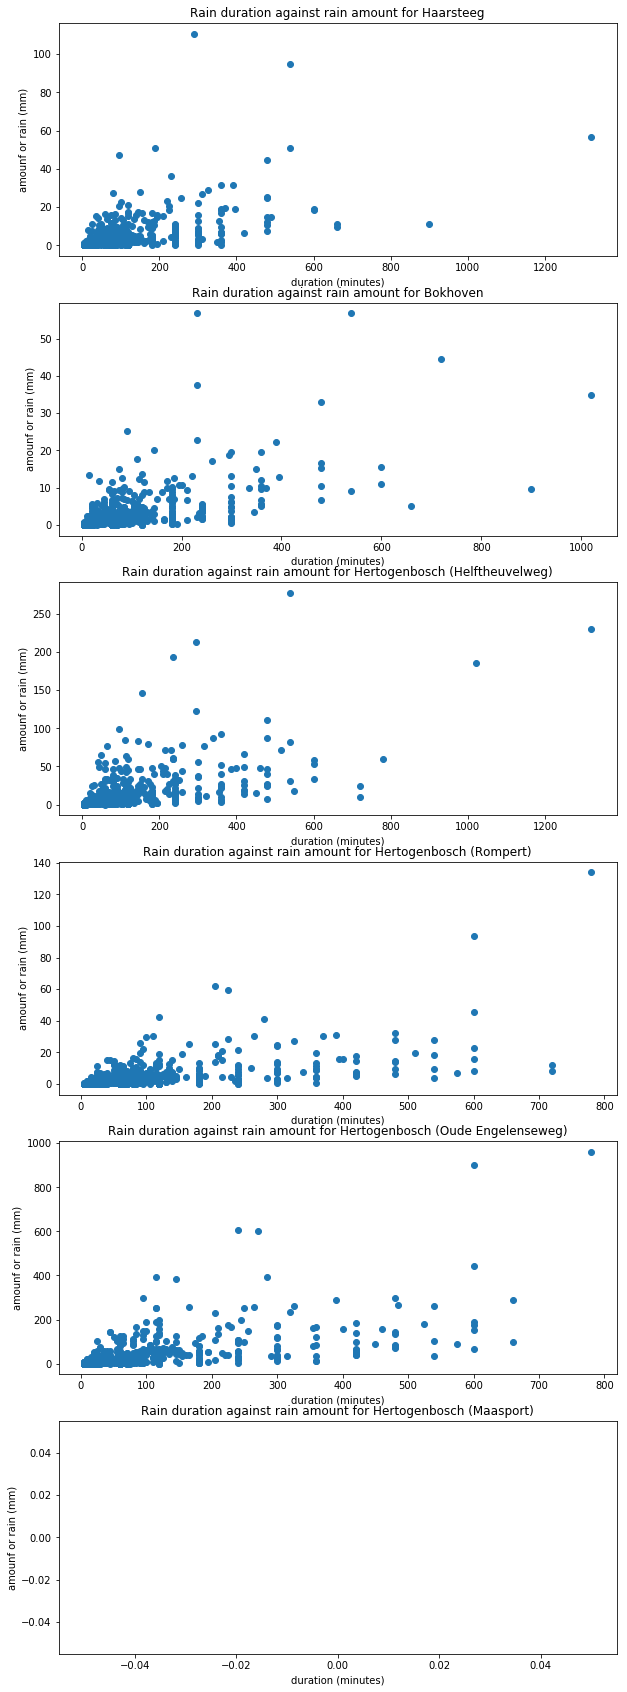

In [12]:
#Plotting duration against amount
plt.figure(figsize=(10,30))
def group_by_event(events_df, station_name, rain_event_col, k):
    df = events_df[k]
    
    #Filtering rain events where there was no rain
    df = df[df[rain_event_col] != "None"]
    
    #should be elsewhere
    df["End"] = pd.to_datetime(df["End"])
    #
    
    #Converting duration of individual measurements to minutes
    df["duration"] = (df["End"] - df["Begin"]).dt.total_seconds()/60
    
    #Filter measurements that last more than 1 week (there are errors in data)
    df = df[(df["duration"] <= 10080) & (df["duration"] >= 0)]
    
    #Group by rain event ID and sum the durations and rain measurements
    df = df[["duration", station_name, rain_event_col]].groupby(rain_event_col).sum()
    return df

#Plotting each station respectively.
def plot_duration_amount(events_df, station_names, rain_event_col):
    
    for k, name in enumerate(station_names):
        station_df = group_by_event(events_df, name, rain_event_col, k)
        plt.subplot(len(station_names), 1, k+1)
        plt.scatter(station_df["duration"], station_df[name])
        plt.title("Rain duration against rain amount for " + name)
        plt.xlabel("duration (minutes)")
        plt.ylabel("amounf or rain (mm)")
        
plot_duration_amount(events_df, station_names, "rain_event_ID")
        
    

# Classifying type of rainy days and visualizing (To be reworked)

In [ ]:
# The sum of the rain at all locations per day
df_dailysum = df.groupby('date').sum()

In [ ]:
# Should be revalued and used in a more useful way
def condition_days(rain_value):
    
    #conditions are made based on wikipedia numbers, intensity section
    #https://en.wikipedia.org/wiki/Rain
    if rain_value == 0:         
        return "No"
    elif 0 < rain_value <= 2.352 :
        return 'Light'
    elif 2.352 < rain_value <= 7.2:
        return 'Moderate'
    elif 7.2 < rain_value <= 48:
        return 'Heavy'
    elif 48 < rain_value:
        return 'Violent'
    else:
        return 'Something went wrong'

    
def class_of_rain(names_list, df_day):
    
    #Adding a column for the type of (rainy) day
    for i in names_list:
        df_day["Rain measure " + i] = df_day.apply(lambda x: condition_days(x[i]), axis=1)
    return df_day   

classes_rain = class_of_rain(station_names, df_dailysum)

#Applying the same label, but for 5 minute interval data
def instr(day, dictio):
    return dictio[day]

def class_rain_5min(names_list, df_5min, df_day):
    for i in names_list:
        dictio = df_day.to_dict()["Rain measure " + i]
        df_5min["Rain measure " + i] = df_5min.apply(lambda x: instr(x["date"], dictio), axis = 1)
    return df_5min

classes_rain2 = class_rain_5min(station_names, df, df_dailysum)

#Flow Data
flow_haarsteeg = pd.concat([pd.read_csv(file) for file in glob.glob(path6+"/*.*")], ignore_index = True)

def bound_dates(df1, df2, df1_datecol, df2_datecol):
    
    # Making sure both have the same range of dates
    df1[df1_datecol] = pd.to_datetime(df1[df1_datecol])
    df2[df2_datecol] = pd.to_datetime(df2[df2_datecol])
    d1 = pd.merge(left=df1, left_on=df1_datecol,
         right=df2, right_on=df2_datecol)
    d2 = pd.merge(left=df2, left_on=df2_datecol,
         right=df1, right_on=df1_datecol)
    
    return d1, d2

classes_rain2, flow_haarsteeg, = bound_dates(classes_rain2, flow_haarsteeg, "Begin", "datumBeginMeting")


Haarsteeg = classes_rain2[["Haarsteeg", "Begin", "Rain measure Haarsteeg"]]
no_rain = set(Haarsteeg[Haarsteeg["Rain measure Haarsteeg"] == "No"]["Begin"].dt.date)
flow_filtered = flow_haarsteeg[flow_haarsteeg["datumBeginMeting"].dt.date.isin(no_rain)]

In [ ]:
#+++

In [ ]:
#HEATMAPS DRY next to WET days
heatdf = flow_filtered[["hstWaarde", "datumBeginMeting"]]
z = heatdf.groupby([heatdf["datumBeginMeting"].dt.weekday, heatdf["datumBeginMeting"].dt.hour]).describe()
z = z["hstWaarde"]["mean"]
z.index.names = ["created_at_day", "created_at_hour"]
z.columns = ["tweet_conv_size", "tweet_mean_conv"]
z = z.unstack().reset_index(drop=False)
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
z['created_at_day'] = z['created_at_day'].apply(lambda x: days[x])
z = z.set_index("created_at_day")
plt.subplots(figsize=(20, 6))
fig = sns.heatmap(z, annot=True, fmt=".2f", cmap = "YlGn", vmin= 300,
                  vmax = 800)
fig.set_title("Heatmap of average flow for Haarsteeg pump on dry-days", size = 16, weight = "bold");
fig.set_xlabel("Hour of the day", size = 14);
fig.set_ylabel("Day of the week", size = 14);

In [ ]:
#All kinds of rain
all_kinds_rain = set(Haarsteeg[Haarsteeg["Rain measure Haarsteeg"] != "No"]["Begin"].dt.date)
flow_filtered2 = flow[flow["datumBeginMeting"].dt.date.isin(all_kinds_rain)]
heatdf2 = flow_filtered2[["hstWaarde", "datumBeginMeting"]]
z = heatdf2.groupby([heatdf2["datumBeginMeting"].dt.weekday, heatdf2["datumBeginMeting"].dt.hour]).describe()
z = z["hstWaarde"]["mean"]
z.index.names = ["created_at_day", "created_at_hour"]
z.columns = ["tweet_conv_size", "tweet_mean_conv"]
z = z.unstack().reset_index(drop=False)
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
z['created_at_day'] = z['created_at_day'].apply(lambda x: days[x])
z = z.set_index("created_at_day")
plt.subplots(figsize=(20, 6))
fig = sns.heatmap(z, annot=True, fmt=".2f", cmap = "YlGn", vmin= 300,
                  vmax = 800)
fig.set_title("Heatmap of average flow for Haarsteeg pump on rainy-days", size = 16, weight = "bold");
fig.set_xlabel("Hour of the day", size = 14);
fig.set_ylabel("Day of the week", size = 14);

In [ ]:
# def method_bisect(a,b,c):
#     b.sort()
#     for i,x in enumerate(a):
#         index = bisect.bisect_left(b,x)
#         if index < len(a):
#             if x == b[index]:
#                 c[i] = 1
#     return(time.time()-start_time)

In [20]:
rainy_day_stations[0]

,Haarsteeg,Begin,previousday,dryday
122688,0.0000,2017-12-31 23:00:00,0.0124,0
122689,0.0124,2018-01-01 00:00:00,0.2245,0
122690,0.2245,2018-01-01 01:00:00,0.0563,1
122691,0.0563,2018-01-01 02:00:00,0.0427,0
122692,0.0427,2018-01-01 03:00:00,0.0044,0
122693,0.0044,2018-01-01 04:00:00,0.0000,0
122694,0.0000,2018-01-01 05:00:00,0.0000,0
122695,0.0000,2018-01-01 06:00:00,0.0000,0
122696,0.0000,2018-01-01 07:00:00,0.0000,0
122697,0.0000,2018-01-01 08:00:00,0.0000,0
